In [29]:
import sys
sys.path.append("../../src")
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

plt.style.use(["science","bright"])

In [30]:
values_AND_9    = [0.085337,0.00,-0.03929,0.00,-0.022938,0.010342,0.002624,0.0,0.0]
values_AND_11   = [0.017308,0.00,0.070893,0.00,0.073702,0.038,0.030185,0.0,0.0]
values_AND_13   = [0.089993,0.00,0.063558,0.00,-0.048817,0.011171,0.037835,0.0,0.0]

values_XOR_9    = [-0.094029,0.00,0.051392,0.00,0.03737,-0.040439,-0.043346,0.0,0.0]
values_XOR_11   = [-0.044536,0.00,0.066428,0.00,0.096061,-0.021845,-0.081427,0.0,0.0]
values_XOR_13   = [-0.070379,0.00,0.091417,0.00,0.08231,-0.015387,-0.013483,0.0,0.0]

voltages        = np.tile(np.round(values_AND_13,4), (4,1))
voltages[:,1]   = [0.0,0.0,0.01,0.01]
voltages[:,3]   = [0.0,0.01,0.0,0.01]
voltages

array([[ 0.09  ,  0.    ,  0.0636,  0.    , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.    ,  0.0636,  0.01  , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.01  ,  0.0636,  0.    , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ],
       [ 0.09  ,  0.01  ,  0.0636,  0.01  , -0.0488,  0.0112,  0.0378,
         0.    ,  0.    ]])

In [31]:
N_p                 = 13
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[0,0,0], [int((N_p-1)/2),0,0], [N_p-1,0,0], 
                            [0,int((N_p-1)/2),0], [0,N_p-1,0], [N_p-1,int((N_p)/2),0],
                            [int((N_p)/2),(N_p-1),0], [N_p-1,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant',
                           'constant','constant','constant','floating']
}
target_electrode    = len(topology_parameter["e_pos"])-1
sim_dic             =   {
    "error_th"        : 0.05,
    "max_jumps"       : 10000000,
    "eq_steps"        : 100000,
    "jumps_per_batch" : 1000,
    "kmc_counting"    : False,
    "min_batches"     : 3
}
# sim_dic             =   {
#     "error_th"        : 0.0,
#     "max_jumps"       : 100000,
#     "eq_steps"        : 100000,
#     "jumps_per_batch" : 1,
#     "kmc_counting"    : False,
#     "min_batches"     : 0
# }

In [32]:
list_results        = []
# target_observables  = []
for i in range(10):
    sim_class   = nanonets.simulation(topology_parameter=topology_parameter)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode, sim_dic=sim_dic, verbose=False)
    results     = sim_class.return_output_values()
    states      = sim_class.return_potential_landscape()*1000
    net_curr    = pd.DataFrame(sim_class.return_network_currents()[1], columns=sim_class.return_network_currents()[0])
    list_results.append(results)
    # target_observables.append(sim_class.target_observable_values[0]*1000)

In [33]:
# plt.figure(dpi=200)
# for target_observable in target_observables:
#     plt.plot(target_observable)
#     plt.xlim(0,2000)

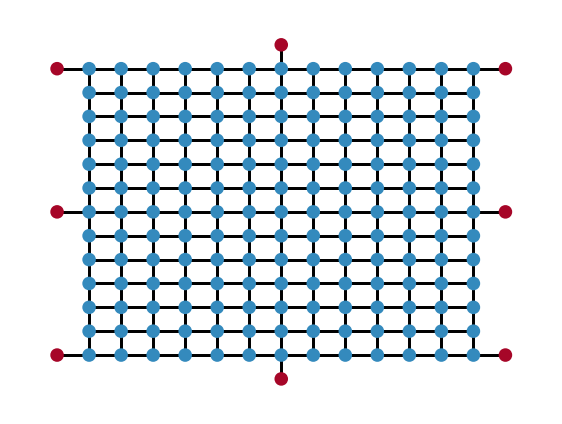

In [34]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
fig, ax = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=15)

Text(0, 0.5, '$U$ [mV]')

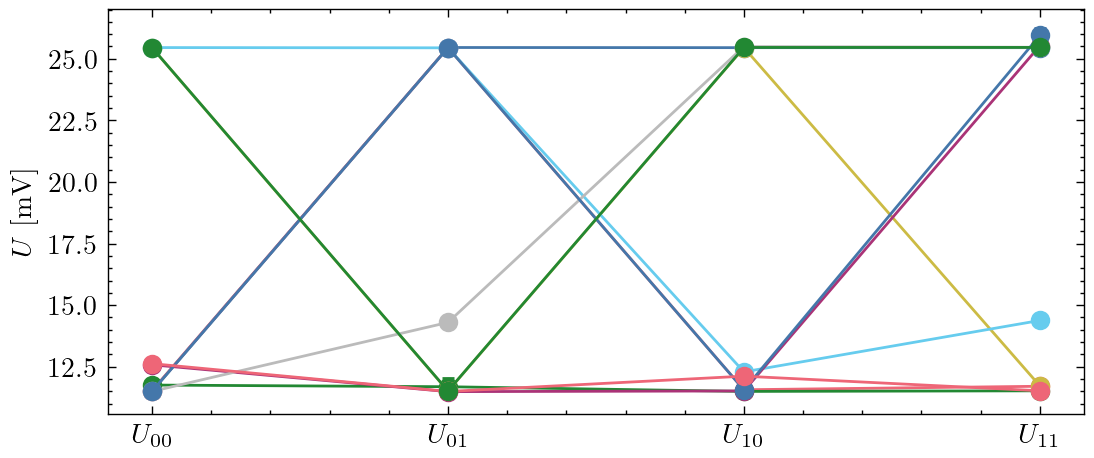

In [35]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot()
for results in list_results:
    ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"],
                results[:,2]*1000, results[:,3]*1000, marker='o', capsize=2)
ax.set_ylabel("$U$ [mV]")

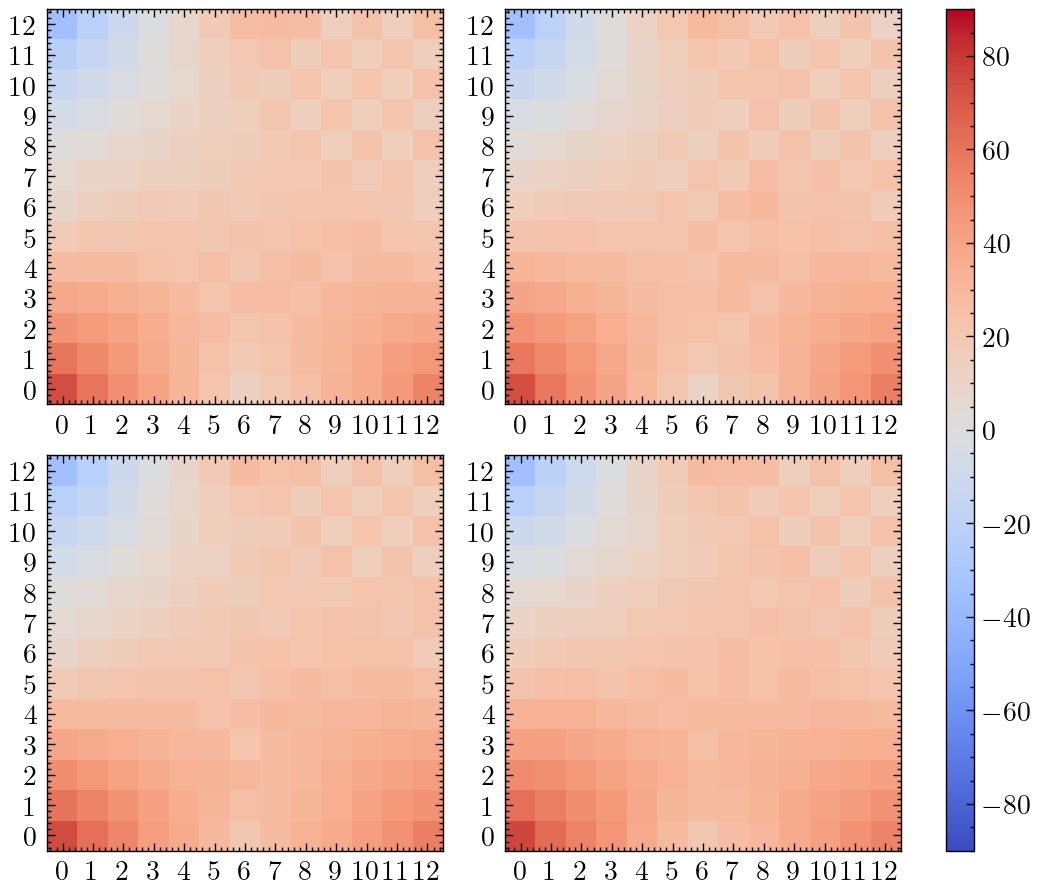

In [36]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figheight(fig.get_figheight()*1.7)
fig.set_figwidth(fig.get_figwidth()*1.5)

vmin = -np.max(np.abs(states))
vmax = np.max(np.abs(states))

# Create subplots and add imshow plots
axes = []
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    im = ax.imshow(states[i, 8:].reshape(N_p, -1), cmap='coolwarm', interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(N_p))
    ax.set_yticks(np.arange(N_p))
    ax.invert_yaxis()
    axes.append(ax)

# Add a figure-level colorbar
fig.colorbar(im, ax=axes, orientation='vertical', shrink=1.0, label="", aspect=30)

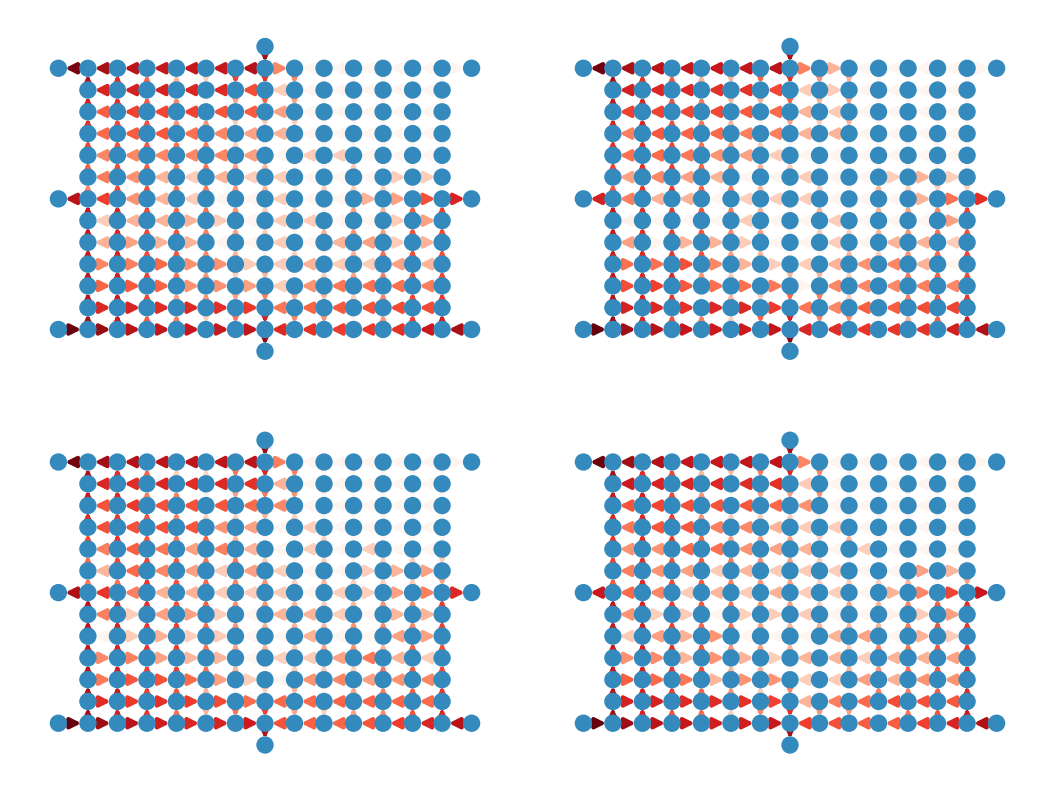

In [37]:
fig = plt.figure(dpi=300, layout='constrained')

for row in range(4):

    ax      = fig.add_subplot(2,2,row+1)
    fig, ax = nanonets_utils.display_network_currents(df=net_curr, row=row, N_electrodes=8, pos=sim_class.pos,
                                                    fig=fig, ax=ax, node_size=10, arrowsize=5)


In [38]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(net_curr.columns)

last_node   = np.max(G.edges)
distances   = [nx.shortest_path_length(G=G, source=i, target=last_node) for i in range(N_p*N_p)]
states_mean = np.mean(states,axis=0)[8:]

In [39]:
state_df = pd.DataFrame([distances,states_mean]).T
state_df

,0,1
0,25.0,73.962427
1,19.0,60.593892
2,13.0,51.121223
3,19.0,42.282099
4,13.0,33.433444
...,...,...
164,12.0,24.065276
165,11.0,16.947411
166,10.0,21.058220
167,9.0,16.436487


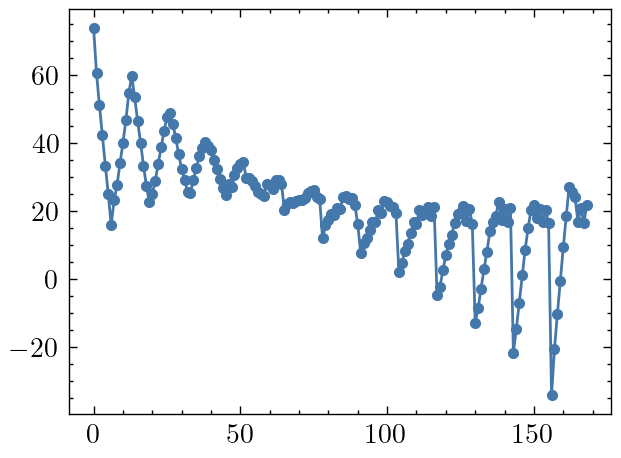

In [40]:
plt.figure(dpi=200)
plt.plot(states_mean, '.-')

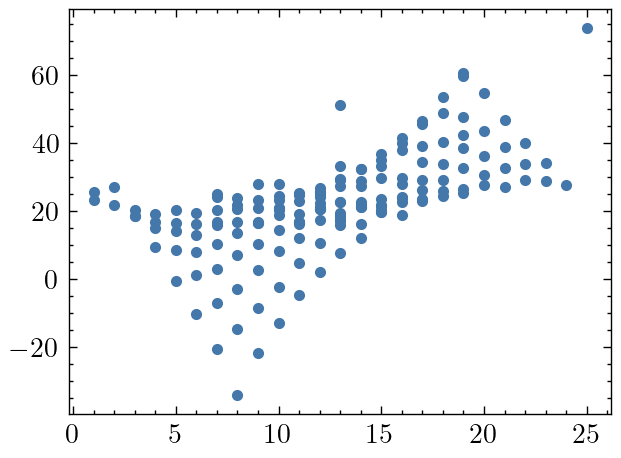

In [41]:
plt.figure(dpi=200)
plt.plot(distances, np.mean(states,axis=0)[8:], '.')

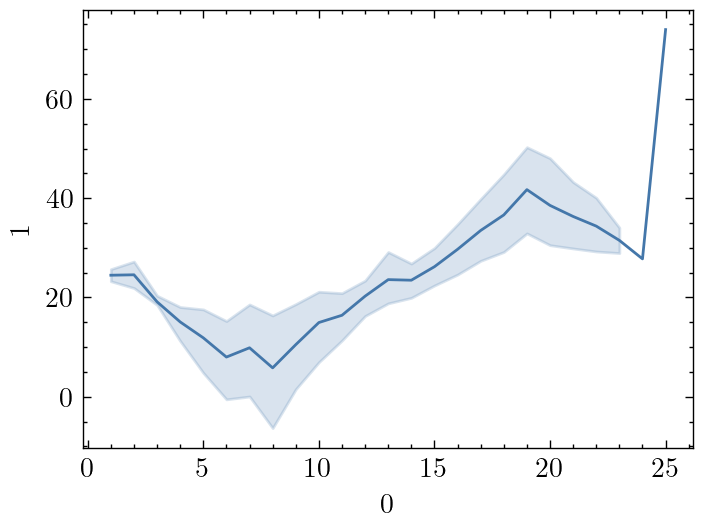

In [42]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax  = sns.lineplot(data=state_df, x=0, y=1, ax=ax, markers=True)